## Tumor boundary and Spatial distance calculation

In [ ]:
library(Seurat)
library(RColorBrewer)
library(tidyverse)

##load ST data
load('~/DATA/code/myCode/ST/ST_RCTD.rdata')
cols <- c(
  "#DC050C", "#FB8072", "#1965B0", "#7BAFDE", "#882E72",
  "#B17BA6", "#FF7F00", "#FDB462", "#E7298A", "#E78AC3",
  "#33A02C", "#B2DF8A", "#55B1B1", "#8DD3C7", "#A6761D",
  "#E6AB02", "#7570B3", "#BEAED4", "#666666", "#999999",
  "#aa8282", "#d4b7b7", "#8600bf", "#ba5ce3", "#808000",
  "#aeae5c", "#1e90ff", "#00bfff", "#56ff0d", "#ffff00")

SpatialPlot(ST,group.by ='Region')& scale_fill_manual(values = cols) &
  theme_bw()&
  theme(axis.text = element_blank(),
        axis.ticks = element_blank(),
        axis.title = element_blank())

In [ ]:
##提取癌灶区域
tumor<-subset(ST, Region %in% 'Mal')
##拆分样本
tumor_list <- SplitObject(tumor, split.by = "orig.ident")

In [ ]:
#定义边界计算脚本
#获取某个spot周围的6个spot
get_circle_n_spot = function(coor_df, spot){
  #spot = as.vector(spot)
  spot_top_left = c(row=spot["row"] + 1, col=spot["col"] - 1)
  spot_top_right = c(row=spot["row"] + 1, col=spot["col"] + 1)
  spot_right = c(row=spot["row"], col=spot["col"] + 2)
  spot_bottom_right = c(row=spot["row"] - 1, col=spot["col"] + 1)
  spot_bottom_left = c(row=spot["row"] - 1, col=spot["col"] - 1)
  spot_left = c(row=spot["row"], col=spot["col"] - 2)
  
  df_circle = data.frame(row=c(spot_top_left[1], spot_top_right[1],spot_right[1],spot_bottom_right[1],spot_bottom_left[1],spot_left[1]),
                         col=c(spot_top_left[2], spot_top_right[2],spot_right[2],spot_bottom_right[2],spot_bottom_left[2],spot_left[2])
  )
  
  df_circle$cor_name = paste0(df_circle$row, "x", df_circle$col)
  df_circle = coor_df[coor_df$cor_name %in% df_circle$cor_name,]
  return(df_circle)
}


#获取一些spot周围的spot
get_circle_all_spot = function(coor_df, spot_all){
  res = purrr::map(rownames(spot_all), function(x){
    df_one = spot_all[x,]
    #pinrt(x)
    df_one = get_circle_n_spot(coor_df=coor_df, spot=c("row"=spot_all[x, "row"], "col"=spot_all[x, "col"]))
    df_one = df_one %>% tibble::rownames_to_column(., "barcode")
    return(df_one)
  }) %>% bind_rows() %>% distinct()
  rownames(res) = res$barcode
  res=res[,!colnames(res) %in% c("barcode")]
  return(res)
}


##将spot分割为区域
get_spot_section = function(selected_df){
  spot_area = list()
  for (row_idx in rownames(selected_df)){
    #idx = 0
    if (row_idx %in% unlist(spot_area))
    {next}
    
    spot_1 = selected_df[row_idx, ]
    
    idx = length(spot_area) + 1      
    spot_area[[idx]] = c(row_idx)
    
    new_spot = get_circle_n_spot(selected_df, spot=c(row=spot_1$row[1], col=spot_1$col[1]))
    if(nrow(new_spot) == 0){next}
    else{
      new_area = c(spot_area[[idx]], rownames(new_spot))
      while(length(new_area) > length(spot_area[[idx]]))
      {
        spot_area[[idx]] = new_area
        new_area_df = get_circle_all_spot(coor_df = selected_df, spot_all=selected_df[spot_area[[idx]],])
        new_area = unique(c(spot_area[[idx]], rownames(new_area_df)))
      }
    }
    
  }
  spot_area = data.frame(barcode = unlist(spot_area), section = rep(seq(length(spot_area)), lengths(spot_area)))
  df_section = left_join(rownames_to_column(selected_df), spot_area, by = c('rowname'="barcode"))
  return(df_section)
}

In [ ]:
#初始化结果列表和空的数据框
results <- list()
combined_spot_filter <- data.frame()

# 遍历每个样本的Seurat对象
for (sample_name in names(tumor_list)) {
  sample_data <- tumor_list[[sample_name]]
  
  # 提取坐标
  coordinates <- sample_data@images[[sample_name]]@coordinates
  
  # 获取坐标的行列最大值
  xDiml <- max(coordinates$row)
  yDiml <- max(coordinates$col)
  
  # 转换坐标
  coordinates$row <- xDiml - coordinates$row
  coordinates$cor_name <- paste0(coordinates$row, "x", coordinates$col)
  
  # 将 spot 分割为区域
  spot_area <- get_spot_section(coordinates)
  
  # 统计每种类型的数量
  section_counts <- table(spot_area$section)
  print(paste("Sample:", sample_name))
  print(section_counts)
  
  # 移除少于 10 个 spot 的区域
  spot_filter <- spot_area %>% group_by(section) %>% filter(n() > 10)
  
  # 添加样本名称列
  spot_filter$sample_name <- sample_name
  
  # 获取区域的外轮廓线
  for (i in spot_filter$rowname) {
    spot <- c("row" = spot_filter$row[spot_filter$rowname == i], "col" = spot_filter$col[spot_filter$rowname == i])
    suround <- get_circle_n_spot(spot_filter, spot)
    if (nrow(suround) < 6) {
      spot_filter[spot_filter$rowname == i, "group"] <- "Bdy"
    } else {
      spot_filter[spot_filter$rowname == i, "group"] <- "Mal"
    }
  }
  
  # 合并结果到 combined_spot_filter
  combined_spot_filter <- rbind(combined_spot_filter, spot_filter)
  
  # 画图
  p <- ggplot(spot_filter, aes(x = col, y = row, colour = section)) + geom_point() + ggtitle(paste("Sample:", sample_name))
  print(p)
  
  # 保存结果
  results[[sample_name]] <- list(
    coordinates = coordinates,
    spot_area = spot_area,
    spot_filter = spot_filter,
    plot = p
  )
}

In [ ]:
##保存边界计算结果
save(combined_spot_filter,file = '~/DATA/code/myCode/ST/combined_spot_filter.rdata')

##提取结果
Bdy<-combined_spot_filter[,c(1,10)]
rownames(Bdy)<-Bdy$rowname

##边界加入ST对象
ST<- AddMetaData(ST,metadata  = Bdy)

# 将 group 列中的 NA 值赋值为 "PT"
ST@meta.data$group[is.na(ST@meta.data$group)] <- "nMal"
SpatialPlot(ST,group.by = 'group',cols = c('nMal'='#FDB462','Mal'='#E31A1C','Bdy'='#1F78B4'))

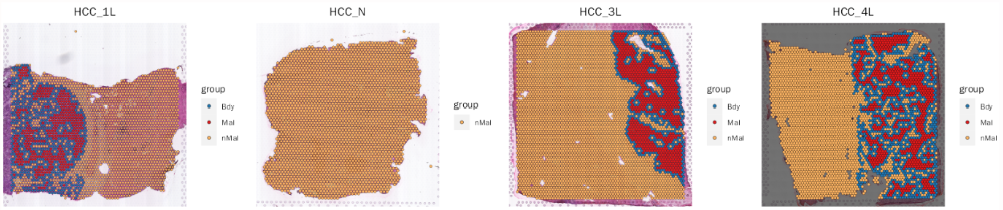

## Boundary  Distance  calculation

In [ ]:
##定义TR过渡区域
ST@meta.data$Label<-ST@meta.data$group
ST@meta.data$Label[ST@meta.data$seurat_clusters %in% c('4','5','7')] <- "TR"
SpatialPlot(ST,group.by = 'Label')

#提取边界-过渡区,创建nMal_list,拆分样本
nMal<-subset(ST,Label  %in% c('Bdy','TR') & orig.ident %in% c('HCC_1L','HCC_3L','HCC_4L'))
SpatialPlot(nMal,group.by = 'Label',images = c('HCC_1L','HCC_3L','HCC_4L'),cols = c('TR'='#55B1B1','Bdy'='#1F78B4'))

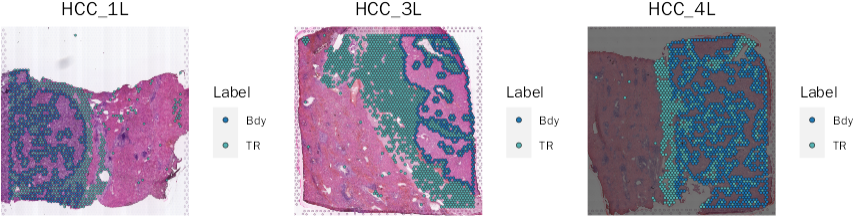

In [ ]:
##拆份样本
nMal_list <- SplitObject(nMal, split.by = "orig.ident")

##HCC_1L样本坐标
HCC1L_spot<-cbind( nMal_list[["HCC_1L"]]@images[["HCC_1L"]]@coordinates,nMal_list[["HCC_1L"]]@meta.data)
##HCC_3L样本坐标
HCC3L_spot<-cbind( nMal_list[["HCC_3L"]]@images[["HCC_3L"]]@coordinates,nMal_list[["HCC_3L"]]@meta.data)
##HCC_4L样本坐标
HCC4L_spot<-cbind( nMal_list[["HCC_4L"]]@images[["HCC_4L"]]@coordinates,nMal_list[["HCC_4L"]]@meta.data)

In [ ]:
#####calculating distance
calSpotSpotDistance <- function(spot1, spot2)
{
  spot1_xy <- as.numeric(unlist(strsplit(spot1,"x")))
  spot2_xy <- as.numeric(unlist(strsplit(spot2,"x")))
  sqrt((spot1_xy[1]-spot2_xy[1])^2+(spot1_xy[2]-spot2_xy[2])^2)
}

calSpotVecDistance <- function(spot1, vec2)
{
  min(sapply(vec2,calSpotSpotDistance,spot1=spot1))
}

calVecVecDistance <- function(vec1,vec2)  # vec1 M2CAF, vec2 border
{
  sapply(vec1,calSpotVecDistance,vec2=vec2)
}



HCC1L_spot$cor_name = paste0(HCC1L_spot$row, "x", HCC1L_spot$col)
#定义TR与Bdy
TR1L = HCC1L_spot[HCC1L_spot$Label == 'TR',]
Bdy1L = HCC1L_spot[HCC1L_spot$Label == 'Bdy',]

##计算TR的spot到Bdy的欧氏距离
TR1L$distance = calVecVecDistance(TR1L$cor_name,Bdy1L$cor_name)

HCC3L_spot$cor_name = paste0(HCC3L_spot$row, "x", HCC3L_spot$col)
#定义TR与Bdy
TR3L = HCC3L_spot[HCC3L_spot$Label == 'TR',]
Bdy3L = HCC3L_spot[HCC3L_spot$Label == 'Bdy',]
TR3L$distance = calVecVecDistance(TR3L$cor_name,Bdy3L$cor_name)

HCC4L_spot$cor_name = paste0(HCC4L_spot$row, "x", HCC4L_spot$col)
#定义TR与Bdy
TR4L = HCC4L_spot[HCC4L_spot$Label == 'TR',]
Bdy4L = HCC4L_spot[HCC4L_spot$Label == 'Bdy',]
TR4L$distance = calVecVecDistance(TR4L$cor_name,Bdy4L$cor_name)

In [ ]:
library(RColorBrewer)
ggplot(TR4L, aes(x = col, y = row, colour = distance)) + geom_point() +  
  scale_color_gradientn(colours = colorRampPalette(colors = rev(brewer.pal(11, name = "Spectral")))(100))

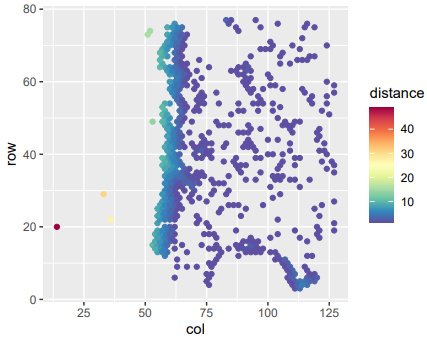

In [ ]:
##合并TR区域距离信息
distance<-rbind(TR1L,TR3L,TR4L)
distance<-distance[,c(24:25)]
save(distance,file = '~/DATA/code/myCode/ST/distance.rdata')

#提取TR区域
TR <-subset(ST, Label %in% 'TR')
TR<- AddMetaData(TR,metadata  = distance)
SpatialPlot(TR,features = 'distance')

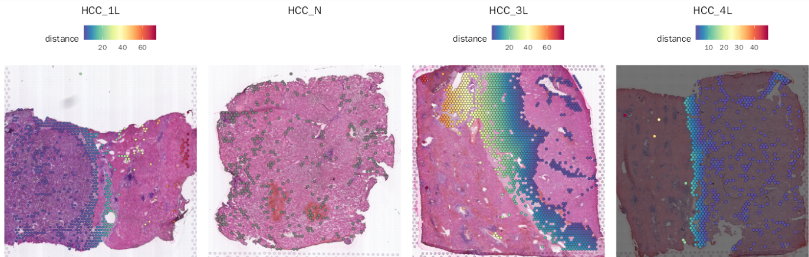

In [ ]:
##提取距离与细胞成分meta.data
TR_df<-TR@meta.data
TR_df_1L<-subset(TR_df, orig.ident %in% 'HCC_1L')
TR_df_3L<-subset(TR_df, orig.ident %in% 'HCC_3L')
TR_df_4L<-subset(TR_df, orig.ident %in% 'HCC_4L')

# 生成曲线图
ggplot(data = TR_df_1L, aes(x = distance, y = Fibroblast, color = seurat_clusters)) +
  geom_point(size = 1) +  # 添加数据点
  geom_smooth(method = 'loess', se = FALSE, color = 'black') +  # 添加平滑曲线
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 0, hjust = 0.5, size = 14, color = "black"),
    axis.text.y = element_text(size = 14, color = "black"),
    axis.title.x = element_text(size = 16, color = "black"),
    axis.title.y = element_text(size = 16, color = "black"),
    plot.title = element_text(hjust = 0.5, size = 20),
    panel.border = element_blank(),  # 移除所有边框线
    panel.grid.major = element_blank(),  # 移除主网格线
    panel.grid.minor = element_blank(),  # 移除次网格线
    axis.line = element_line(color = "black"),  # 仅保留下方和左边的边框线
    legend.text = element_text(size = 14),  # 增大图例文本
    legend.title = element_text(size = 16)  # 增大图例标题
  ) +
  labs(title = "Fibroblast",
       x = "Distance",
       y = "Cell percentage")+
      scale_color_manual(values = c("4" = "#386cb0", "5" = "#f0027f", "7" = "#fdc086")) # 根据cluster自定义颜色

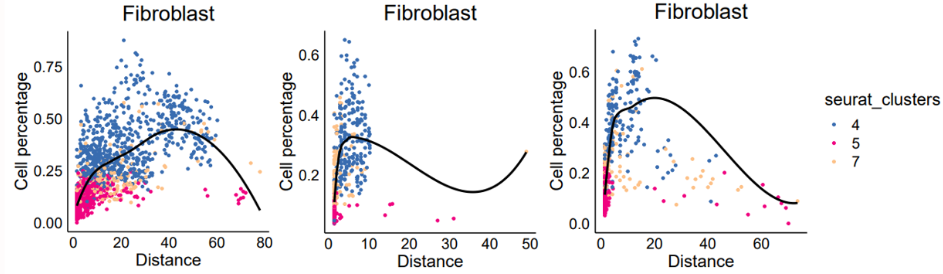

## Tumor-Bdy-TR analysis

In [ ]:
SpatialPlot(ST,group.by = 'Label')

subST<-subset(ST,Label %in% c('Bdy','TR','Mal') & orig.ident %in% c('HCC_1L','HCC_3L','HCC_4L'))
SpatialPlot(subST,group.by = 'Label')

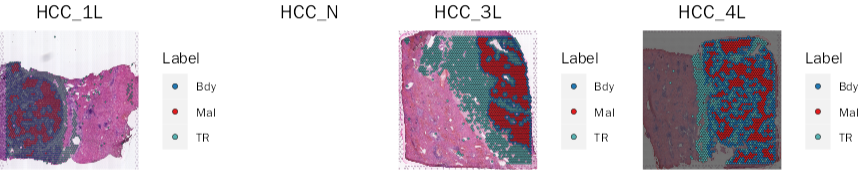

In [ ]:
##重新走SCT标准化
subST <- SCTransform(subST, assay = "Spatial")
subST <- RunPCA(subST, assay = "SCT") 

###区域间差异分析
Idents(subST)<-subST@meta.data$Label
DEG<-FindAllMarkers(subST,only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

##可视化差异基因,修改jjVolcano函数
library(scRNAtoolVis)
jjVolcano(diffData = DEG,
          topGeneN = 5,
          col.type='adjustP',
          legend.position=c(0.45,0.9),
          tile.col= c('TR'='#55B1B1','Mal'='#E31A1C','Bdy'='#1F78B4'))

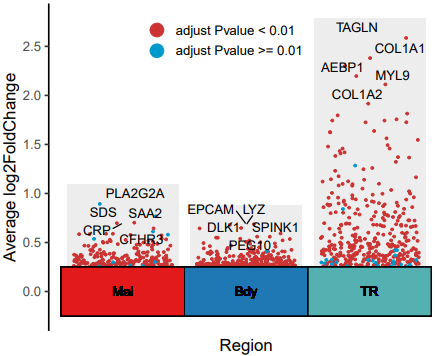

In [ ]:
##Enrichment analysis
library(clusterProfiler)
#将基因SYMBOL转换为ENTREZID
gid <- bitr(unique(DEG$gene), 'SYMBOL', 'ENTREZID', OrgDb= 'org.Hs.eg.db')
markers <- full_join(DEG, gid, by=c('gene' = 'SYMBOL'))

#GO Enrichment：BP
GO = compareCluster(ENTREZID ~ cluster, data = markers, fun='enrichGO', OrgDb='org.Hs.eg.db',ont='BP')

#可视化各区域TOP4通路
dotplot(GO, label_format=40,showCategory=4) + 
  theme(axis.text.x = element_text(angle=45, hjust=1)) +  
  xlab('Region')+
  scale_color_gradientn(colours = colorRampPalette(colors = brewer.pal(11, name = "PiYG"))(100))

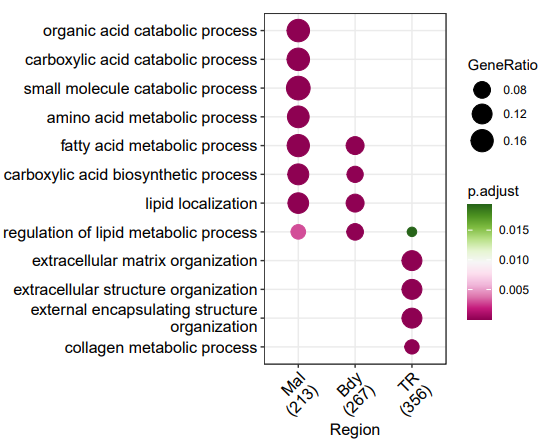

In [ ]:
#将EntrezID转换为Symbol
GO = setReadable(GO, #前面分析的结果
                 OrgDb = "org.Hs.eg.db", #人
                 keyType = "ENTREZID") #转换的基因类型
save(subST,file = '~/DATA/code/myCode/ST/subST.rdata')

## Mal-Bdy-TR LR analysis

In [ ]:
library(CellChat)
cellchat <- createCellChat(object = subST, 
                           group.by = "Label", 
                           assay = "SCT")
CellChatDB <- CellChatDB.human # use CellChatDB.mouse if running on mouse data
showDatabaseCategory(CellChatDB)

# use Secreted Signaling
CellChatDB.use <- subsetDB(CellChatDB, search = "Secreted Signaling", key = "annotation")
cellchat@DB <- CellChatDB.use

#预处理用于细胞间通信分析的表达数据
cellchat <- subsetData(cellchat) # This step is necessary
future::plan("multisession", workers = 4)
##识别过表达基因
cellchat <- identifyOverExpressedGenes(cellchat)
##识别过表达配体受体对
cellchat <- identifyOverExpressedInteractions(cellchat)

##推断 cell-cell communication network
cellchat <- computeCommunProb(cellchat, raw.use = TRUE, population.size = TRUE) 
cellchat <- filterCommunication(cellchat, min.cells = 10)
##保存全部结果
df.net <- subsetCommunication(cellchat)

##从信号通路水平推断细胞间通讯
cellchat <- computeCommunProbPathway(cellchat)
##计算整合的细胞类型之间通信结果
cellchat <- aggregateNet(cellchat)


##visualize 
col= c('TR'='#55B1B1','Mal'='#E31A1C','Bdy'='#1F78B4')
groupSize <- as.numeric(table(cellchat@idents))
par(mfrow = c(1,2), xpd=TRUE)
netVisual_circle(cellchat@net$count, vertex.weight = groupSize, weight.scale = T, label.edge= F, 
                 title.name = "Number of interactions",color.use = col)
netVisual_circle(cellchat@net$weight, vertex.weight = groupSize, weight.scale = T, label.edge= F, 
                 title.name = "Interaction weights/strength",color.use = col)

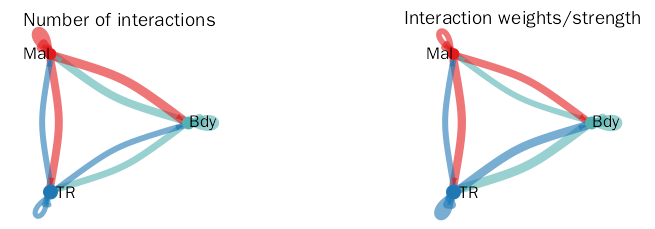

In [ ]:
##显著通路
cellchat@netP$pathways
pathways.show <- c("VEGF")  

levels(cellchat@idents)   

# Circle plot
library(ggpubr)
par(mfrow=c(1,1))
p1<-netVisual_aggregate(cellchat, signaling = pathways.show, layout = "circle",color.use = col)
p2<-netVisual_aggregate(cellchat, signaling = pathways.show, layout = "chord",color.use = col)
ggarrange(p1,p2)

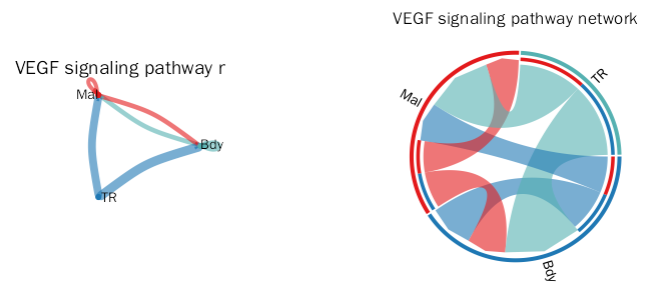

In [ ]:
# Heatmap
par(mfrow=c(1,1))
netVisual_heatmap(cellchat, signaling = pathways.show, color.heatmap ="Reds",
                  color.use =col)

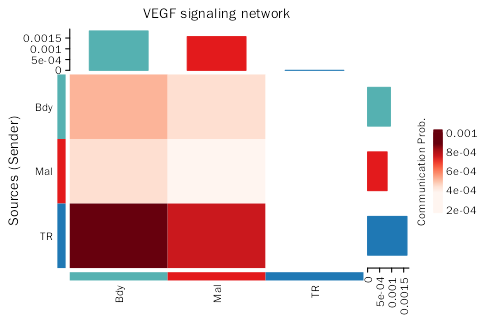

In [ ]:
##计算每个配体-受体对的贡献
netAnalysis_contribution(cellchat, signaling = pathways.show)

##配体-受体对Circle plot
pairLR.CXCL <- extractEnrichedLR(cellchat, signaling = pathways.show, geneLR.return = FALSE)
LR.show <- pairLR.CXCL[1,] # show one ligand-receptor pair
netVisual_individual(cellchat, signaling = pathways.show, pairLR.use = LR.show, layout = "circle")


##L-R pairs Bubble plot
levels(cellchat@idents)
netVisual_bubble(cellchat, sources.use = c(2,3), targets.use = c(1), remove.isolate = FALSE,dot.size.min=2,dot.size.max=7,angle.x = 45,font.size = 16)

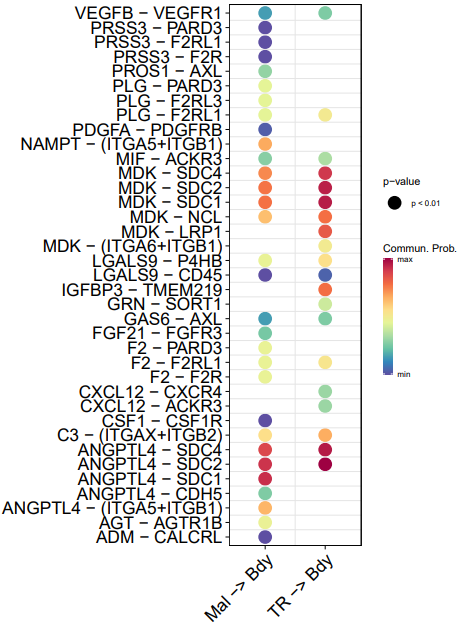

In [ ]:
##Plot the signaling gene expression
plotGeneExpression(cellchat, signaling = "VEGF", enriched.only = TRUE, type = "violin",color.use = col)

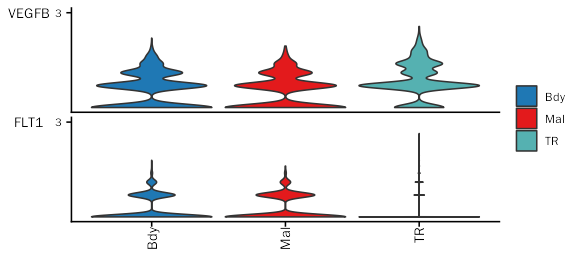

### Written by 孟德尔的豌豆